In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


Epoch 000, Loss: 1.3811, Val Acc: 0.1500
Epoch 010, Loss: 1.1908, Val Acc: 0.2000
Epoch 020, Loss: 1.0432, Val Acc: 0.2000
Epoch 030, Loss: 0.8822, Val Acc: 0.1000
Epoch 040, Loss: 0.7125, Val Acc: 0.1500
Epoch 050, Loss: 0.5472, Val Acc: 0.1500
Epoch 060, Loss: 0.3996, Val Acc: 0.2000
Epoch 070, Loss: 0.2869, Val Acc: 0.3000
Epoch 080, Loss: 0.2058, Val Acc: 0.2500
Epoch 090, Loss: 0.1479, Val Acc: 0.2500


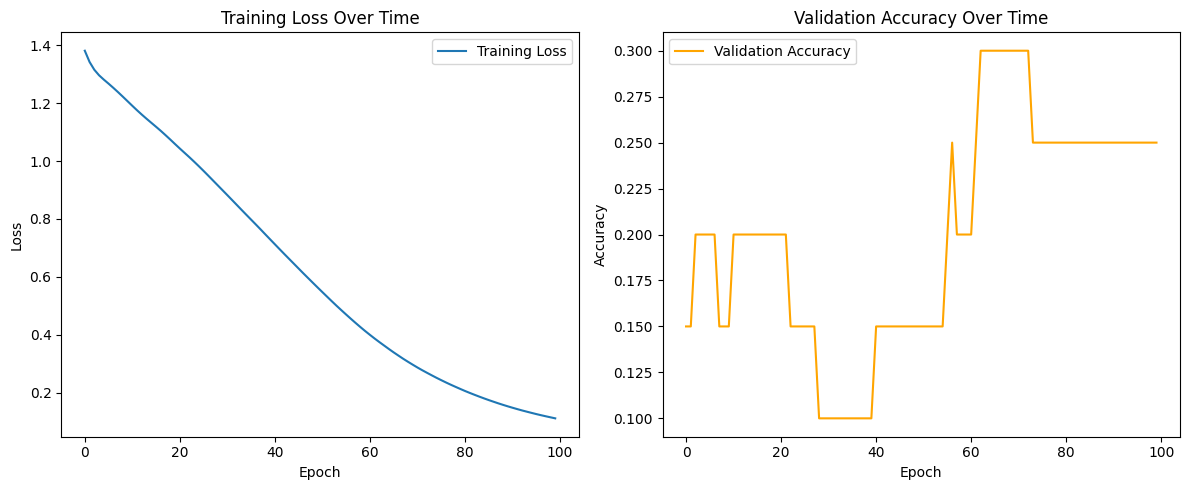

Test Accuracy: 0.1429


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch_geometric.utils import from_networkx

# Генерация синтетического графа
def generate_synthetic_graph(num_nodes=100, num_classes=4):
    G = nx.karate_club_graph()
    G = nx.disjoint_union(G, G)
    G = nx.disjoint_union(G, G)

    # Создаем признаки вершин и метки классов
    features = np.random.randn(len(G), 10)  # 10 признаков на вершину
    labels = np.random.randint(0, num_classes, len(G))

    return G, features, labels

# Класс DCNN
class DiffusionCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_diffusion_steps=3):
        super(DiffusionCNN, self).__init__()
        self.num_diffusion_steps = num_diffusion_steps
        self.hidden_dim = hidden_dim

        # Слои для каждого шага диффузии
        self.diffusion_layers = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim) for _ in range(num_diffusion_steps)
        ])

        # Финальный классификатор
        self.classifier = nn.Linear(hidden_dim * num_diffusion_steps, output_dim)

    def forward(self, x, adj):
        # Нормализация матрицы смежности
        adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-12)

        # Собираем представления для каждого шага диффузии
        representations = []
        x_step = x

        for i in range(self.num_diffusion_steps):
            # Диффузия информации
            x_step = torch.spmm(adj, x_step)

            # Преобразование через линейный слой
            x_transformed = self.diffusion_layers[i](x_step)
            x_transformed = F.relu(x_transformed)

            representations.append(x_transformed)

        # Объединяем представления
        combined = torch.cat(representations, dim=1)

        # Классификация
        out = self.classifier(combined)

        return F.log_softmax(out, dim=1)

# Функция для визуализации графа
"""def visualize_graph(G, labels, node_size=50):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=labels, cmap=plt.cm.tab10,
            node_size=node_size, with_labels=False)
    plt.title("Graph Structure with Node Classes")
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab10),
                 label="Node Class")
    plt.show()"""

# Функция для визуализации обучения
def plot_training(epochs, train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Основной код
def main():
    # Параметры
    input_dim = 10
    hidden_dim = 32
    output_dim = 4
    num_diffusion_steps = 3
    epochs = 100
    lr = 0.01

    # Генерация данных
    G, features, labels = generate_synthetic_graph(num_nodes=100, num_classes=output_dim)
   # visualize_graph(G, labels)

    # Преобразование в формат PyTorch
    data = from_networkx(G)
    data.x = torch.tensor(features, dtype=torch.float)
    data.y = torch.tensor(labels, dtype=torch.long)

    # Матрица смежности
    adj = torch.eye(len(G))
    for edge in G.edges():
        adj[edge[0], edge[1]] = 1
        adj[edge[1], edge[0]] = 1

    # Разделение на train/val/test
    num_nodes = len(G)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Простое разделение - первые 70% train, затем 15% val, 15% test
    train_mask[:int(0.7*num_nodes)] = True
    val_mask[int(0.7*num_nodes):int(0.85*num_nodes)] = True
    test_mask[int(0.85*num_nodes):] = True

    # Модель и оптимизатор
    model = DiffusionCNN(input_dim, hidden_dim, output_dim, num_diffusion_steps)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    # Обучение
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(data.x, adj)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Валидация
        model.eval()
        with torch.no_grad():
            pred = model(data.x, adj).argmax(dim=1)
            val_acc = accuracy_score(data.y[val_mask].numpy(), pred[val_mask].numpy())
            val_accuracies.append(val_acc)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

    # Визуализация обучения
    plot_training(epochs, train_losses, val_accuracies)

    # Тестирование
    model.eval()
    with torch.no_grad():
        pred = model(data.x, adj).argmax(dim=1)
        test_acc = accuracy_score(data.y[test_mask].numpy(), pred[test_mask].numpy())
        print(f'Test Accuracy: {test_acc:.4f}')

    # Визуализация предсказаний
  #  visualize_graph(G, pred.numpy(), node_size=50)

if __name__ == '__main__':
    main()